# Malaria Cell Images Dataset



### Goal

For this project, we work with work with the Malaria Cell Images Dataset obtained from Kaggle: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria. Using a Deep Learning neural network, our goal here will be to predict the if a cell is Infected or Uninfected by Malaria. 

### The Dataset

The data appear along with the publication:Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR. (2018) Pre-trained convolutional neural networks as feature extractors toward improved Malaria parasite detection in thin blood smear images. PeerJ6:e4568 https://doi.org/10.7717/peerj.4568


# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import tensorflow as tf
%matplotlib inline

# Import the dataset

Since the data is already split lets unpack it with x_train, y_train,x_test, y_test

In [2]:
my_data_dir = 'C:\\Users\\pc\\Documents\\GitHub\\data-science-portfolio\\Data science portfolio\\Convolutional Neural Networks for Image Classification\\Malaria Cell Images Dataset\\cell_images'
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

# The data

In [3]:
os.listdir(train_path+'\\parasitized')[2]

'C100P61ThinF_IMG_20150918_144104_cell_164.png'

In [4]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_164.png'

In [5]:
img= imread(para_cell)

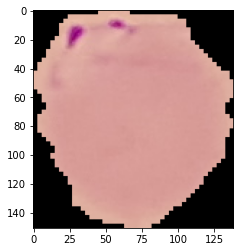

In [6]:
plt.imshow(img)

In [7]:
img.shape

(151, 139, 3)

In [8]:
print(len(os.listdir(train_path+'\\parasitized')))
print(len(os.listdir(train_path+'\\uninfected')))

12480
12480


In [9]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

<AxesSubplot:ylabel='Count'>

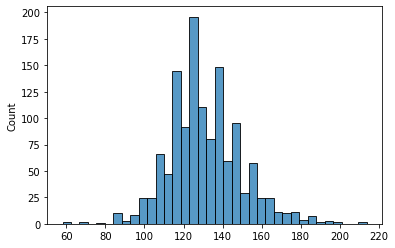

In [10]:
sns.histplot(dim1)

<AxesSubplot:ylabel='Count'>

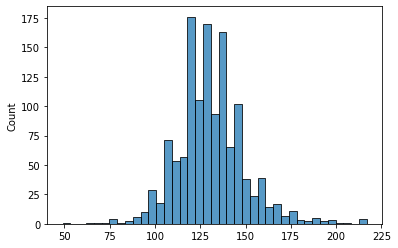

In [11]:
sns.histplot(dim2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


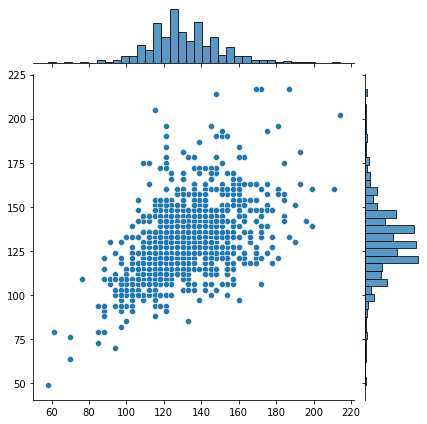

In [12]:
sns.jointplot(dim1,dim2)

In [13]:
print(np.mean(dim1))
print(np.mean(dim2))

130.92538461538462
130.75


In [14]:
image_shape = (130,130,3)

it looks like we gonna have to use a standar size of 130px,130px in order to train our model.

# Data Processing



### Image Manipulation with ImageDataGenerator librairy

A good way to make our model more robust is to manipulate our image to have more data. We will use the ImageDataGenerator librairy to do it.



In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.10, 
                               height_shift_range=0.10, 
                               rescale=1/255, 
                               shear_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

In [17]:
print(img.min())
print(img.max())

0.0
0.8980392


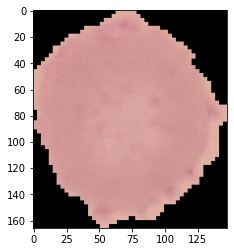

In [18]:
plt.imshow(img)

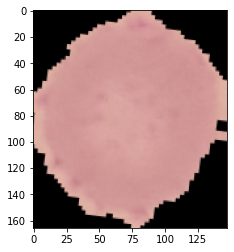

In [19]:
plt.imshow(image_gen.random_transform(img))

As we can se the ImageDataGenerator is modifying the image in order to mix a little more or data in order to get better result later.

# Applying the generator on all image

In [20]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [21]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D



In [23]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(4,4),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size=(4,4),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())


model.add(Dense(256))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## CNN Model info

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 96)        98400     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16224)             0

## Training the CNN Model

In [26]:

batch_size = 12

In [27]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [28]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
2080/2080 [==============================] - 649s 312ms/step - loss: 0.6931 - accuracy: 0.5158 - val_loss: 0.6847 - val_accuracy: 0.5488
Epoch 2/20
2080/2080 [==============================] - 632s 304ms/step - loss: 0.6797 - accuracy: 0.5778 - val_loss: 0.6548 - val_accuracy: 0.6369
Epoch 3/20
2080/2080 [==============================] - 632s 304ms/step - loss: 0.6446 - accuracy: 0.6363 - val_loss: 0.6308 - val_accuracy: 0.6519
Epoch 4/20
2080/2080 [==============================] - 631s 303ms/step - loss: 0.6168 - accuracy: 0.6716 - val_loss: 0.6426 - val_accuracy: 0.6604
Epoch 5/20
2080/2080 [==============================] - 631s 304ms/step - loss: 0.5961 - accuracy: 0.6935 - val_loss: 0.5824 - val_accuracy: 0.7081
Epoch 6/20
2080/2080 [==============================] - 628s 302ms/step - loss: 0.5536 - accuracy: 0.7353 - val_loss: 0.4970 - val_accuracy: 0.7673
Epoch 7/20
2080/2080 [==============================] - 627s 301ms/step - loss: 0.4721 - accuracy: 0.8004 - val_

# Evaluating the Model

In [31]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

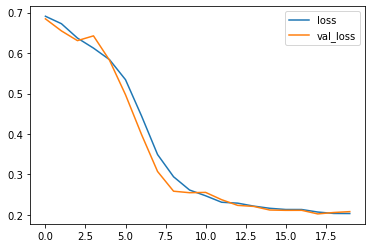

In [32]:
losses[['loss','val_loss']].plot()

In [33]:
model.evaluate_generator(test_image_gen)

[0.20772527158260345, 0.930384635925293]

In [35]:
from tensorflow.keras.preprocessing import image

In [37]:
pred_probabilities = model.predict_generator(test_image_gen)

In [38]:
predictions = pred_probabilities > 0.5

In [39]:
from sklearn.metrics import classification_report,confusion_matrix

In [40]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1300
           1       0.91      0.96      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



In [41]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1182,  118],
       [  57, 1243]], dtype=int64)

# Predicting on one Image

In [42]:
my_image = image.load_img(para_cell,target_size=image_shape)

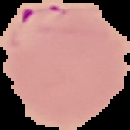

In [43]:
my_image

In [44]:
my_image = image.img_to_array(my_image)

In [45]:
my_image = np.expand_dims(my_image, axis=0)

In [46]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [49]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

# Conclusion

The model looks pretty good with 93% accuracy. I could do more calibration on the number of layer or neurons but since the model take some time to train, im pretty happy with this.